In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import cv2 as cv
import numpy as np
from utils.io_utils import get_images, output_stereo_calib_results, draw_stereo_pair, draw_stereo_pair_detections
from utils.calib_utils import detect_keypoints, filter_orientation_stereo, get_stereo_calib_input

In [11]:
pattern_size = (8, 6)
edge_length = 0.035

data_path1 = "/home/konstantin/datasets/bandeja-sequence/2020-11-17-18-52-32-chess/camera0"
data_path2 = "/home/konstantin/datasets/bandeja-sequence/samsung/20201117_185235_CHESS"

# Data timesteps are not in synch so manual selection of pairs for stereo calib is required

image_names1 = ['1605628353112004352.jpg',
                '1605628358912127232.jpg',
                '1605628364911643136.jpg',
                '1605628369911900416.jpg',
                '1605628376112852224.jpg',
                '1605628380111790592.jpg',
                '1605628388711998464.jpg']

image_names2 = ['1301142278530082.jpg',
                '1301148277753155.jpg',
                '1301154276967035.jpg',
                '1301160276183569.jpg',
                '1301164942237335.jpg',
                '1301170274874331.jpg',
                '1301177607251287.jpg']

pair_dict = {}

for im_n1i, im_n2i in zip(image_names1, image_names2):
    pair_dict[im_n1i] = im_n2i

In [12]:
images1 = get_images(data_path1, file_name_list=image_names1)
images2 = get_images(data_path2, file_name_list=image_names2)

In [13]:
results1 = detect_keypoints(images1, pattern_size, edge_length)
results2 = detect_keypoints(images2, pattern_size, edge_length)

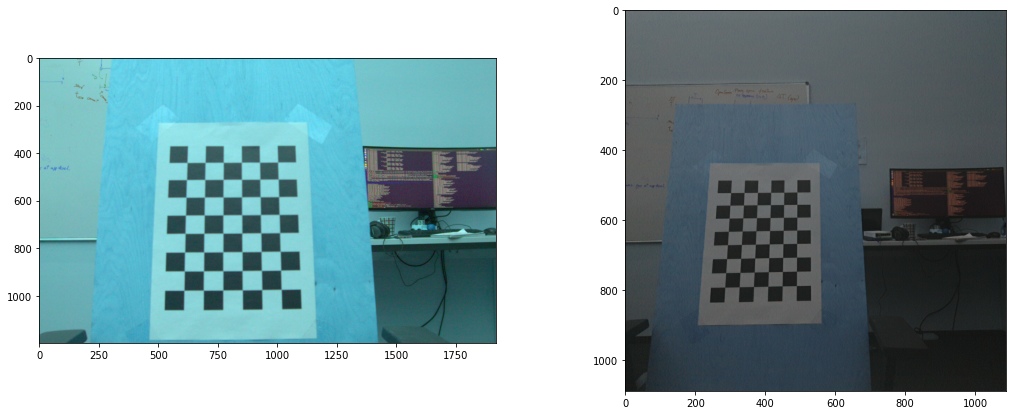

In [14]:
draw_stereo_pair(images1, images2, 0, pair_dict)

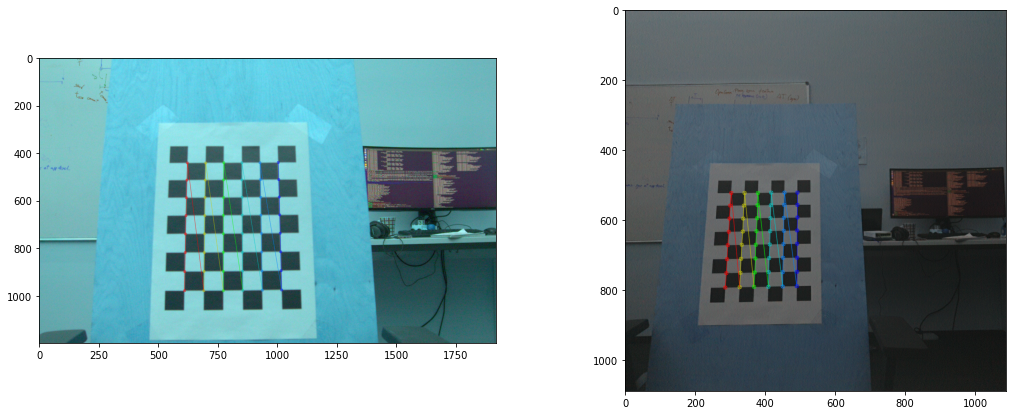

In [15]:
draw_stereo_pair_detections(images1, images2, results1, results2, pattern_size, 0, pair_dict)

In [16]:
calib_intrinsics1 = np.load('calib_output/basler0_intrinsics.npy', allow_pickle=True).item()
calib_intrinsics2 = np.load('calib_output/s10_intrinsics.npy', allow_pickle=True).item()

In [17]:
intrinsics1 = calib_intrinsics1['intrinsics']
dist_coeff1 = calib_intrinsics1['dist_coeff']

intrinsics2 = calib_intrinsics2['intrinsics']
dist_coeff2 = calib_intrinsics2['dist_coeff']

In [19]:
# Make sure keypoints have the same orientation
fresults1, fresults2 = filter_orientation_stereo(results1, results2, pattern_size, pair_dict)

scene_points, loc_kp1, loc_kp2 = get_stereo_calib_input(fresults1, fresults2, pair_dict)

In [20]:
shape = images1[list(images1.keys())[0]].shape[::-1][1:]

reproj_error, _, _, _, _, R12, T12, E12, F12 = cv.stereoCalibrate(scene_points, loc_kp1, loc_kp2, 
                                                                  intrinsics1, dist_coeff1, 
                                                                  intrinsics2, dist_coeff2,
                                                                  shape, flags=cv.CALIB_FIX_INTRINSIC)

print(reproj_error)

0.7305053018443152


R:
[[ 0.99989302  0.0053332   0.01362024]
 [-0.00553105  0.99987913  0.01453035]
 [-0.0135411  -0.01460413  0.99980166]]
T:
[[-0.12383856]
 [ 0.04627057]
 [ 0.10807755]]
E:
[[-2.87720090e-05 -1.08740227e-01  4.46909879e-02]
 [ 1.06389076e-01 -1.23215594e-03  1.25286043e-01]
 [-4.55806626e-02 -1.24070366e-01 -2.42963385e-03]]
F:
[[ 5.26736487e-10  1.99088558e-06 -2.93448780e-03]
 [-1.95451777e-06  2.26381593e-08 -3.12254765e-03]
 [ 1.99906217e-03  1.46473449e-03  1.00000000e+00]]
Saved calibration results as calib_output/basler02s10_extrinsics.npy


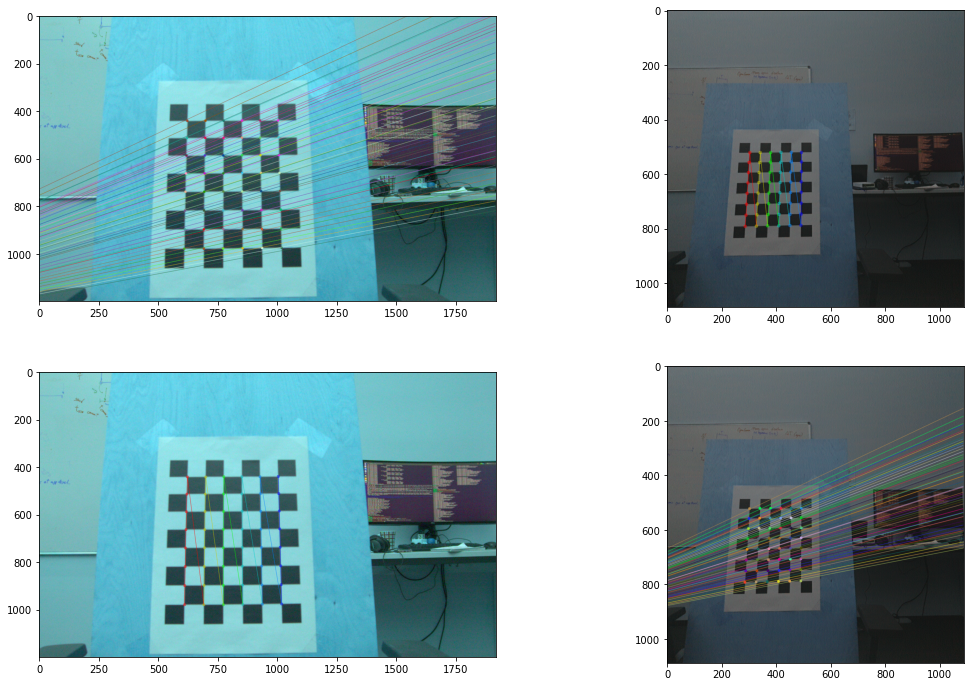

In [21]:
calib_name = "basler02s10"
output_stereo_calib_results(R12, T12, E12, F12, images1, images2, results1, results2, pattern_size, 0, pair_dict, calib_name)
